# Project: PFR  reactor design

In this project you will design a PFR (plug flow reactor) optimized to produce a given particle number distribution. First we introduce the governing equations.

The general dynamic equation which incorporates convective diffusion is given by (Friedlander, 2000; p. 306-307):

$$
\frac{\partial n_{k}}{\partial t}+\nabla \cdot n_{k} \mathbf{v}=\nabla \cdot D \nabla n_{k}+\left[\frac{\partial n_{k}}{\partial t}\right]_{\text {growth }}+\left[\frac{\partial n_{k}}{\partial t}\right]_{c_{k} \phi}-\nabla \cdot \mathbf{c} n_{k}
$$

The mass balance in the PFR with a volume $B$ is given by

$$
\frac {d F_N}{dV} = r_N
$$

And the Smoluchowski type aggregation model:

$$
\begin{split}
& \frac{\partial n(v_p,t)}{\partial t} =
\frac{1}{2}\int_0^{v_p} \beta(\tilde{v_p},v_p-\tilde{v_p}) \, n(\tilde{v_p},t) \, n(v_p-\tilde{v_p},t) \, d\tilde{v_p} 
- \int_0^{\infty} \beta(v_p,\tilde{v_p}) \, n(v_p,t) \, n(\tilde{v_p},t) \, d\tilde{v_p} 
\end{split}
$$



providing:
$$
\frac {d F_N}{dV} = \frac{\partial n(v_p,t)}{\partial t} / B
$$

where $F_N$ is a vector of the number flowrates of particles of each volume.


Task 1 (20%): For a residence time of $\tau = B/Q = 2$ s, and a reactor of size $B = 1$ m$^3$, write a simulation of a PFR reactor with an initial input steam that has the following variables:

- $F_{0} = 10^{17}$ $(\#$ particles m$^{-1}$ s$^{-1}$)
- $n_{0}= N_{0} \delta\left(v-v_{0}\right)$ (monodisperse as above)
- $Q = 0.5~($m$^{3}$s$^{-1}$)

For the particle volumes use
- $d_p$ (min) $= 0.5 \times 10^{-9}$ (m)
- $d_p$ (max) $= 1000 \times 10^{-9}$ (m)




Task 2 (20%): For a conservation of mass validation comparing the mass flow compute the volume of the particles entering and leaving the reactor.

Task 3 (60%): Add in a recycle stream to your PFR reactor. Find the recyle ratio $R$ that produces the number average particle distribution of $d_{p, avg} = 3.5 \times 10^{-9}$. 

The number average particle distribution can be found using the following function from a vector $n$:

```python
# Function for computing number average particle distribution
def dp_avg(n, dp):
    return np.sum(n * dp) / np.sum(n)
```

Task 4 (30%): Use the solution from CSTR reactor below and compare the performance of the CSTR with the PFR reactor by sizing the materials 

In [6]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt
# imports and parameters
# Parameters
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi * (dp_min)**3  /6          # [m^3] Start-Volumen
vp_max = np.pi * (dp_max)**3  /6         # [m^3] End-Volumen
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2) # Schrittweite
Q = 0.5 # Volumenstrom
B = 0.5 # Reaktorvolumen 
tau = B/Q # Verweilzeit

# Initial particle size
dp_0 = 0.5e-9
vp_0 = np.pi * (dp_0)**3  /6
N_0 = 1e17 #start_Zahl
A = 1e-1 # für q(v)

# Initialization for vspan
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)
vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 

# Particle diameter span:
dp = ( 6 * vp/ np.pi)**(1/3.0)

# Analytic solution
# functions
def fun_q(v): 
    return A * v **(1/3)


def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp(
            (3/2.0) * (vp_0**(2/3.0) - v**(2/3.0))/(A * tau)
            ) * (N_0 / tau)

# Function to compute the number average particle distribution
def dp_avg(n, dp):
    """
    For a given particle distrubtion, return the number average particle distribution
    
    Params
    -----
    n : vector or array, particle number distribution
    dp : vector or array, particle diameter matching distribution `n``
    
    Returns
    -------
    dp, scalar, number average particle diameter
    """
    return np.sum(n * dp) / np.sum(n)


# Main CSTR loop:
# dy / dt = f(t, y)
# d(nq) / dv = f(v, nq) = n_0/tau - n/tau
def dnqdv(v, nq):
    n = nq/q
    if nq == y0:
        dnqdv = n_0/tau - n/tau
    else: 
        dnqdv = n/tau
    return dnqdv


# Volume span:
v_span = vp

# Initial value:
q = A * vp_min **(1/3.0)
n_0 = N_0
y0 =  [N_0 * q]

# Solver options
options = {'rtol': 1e-12,
           'atol': 1e-12}

# Initialise data containers.
res_nq_list = []  # nq variable to be integrated
res_v_list = []  # v indepedent variable
vpn = vp.copy()
rv = 0.0
vp_min_n = vp_min
while rv < (vp_max * 0.99):
    # Solve the ivp:
    res = scipy.integrate.solve_ivp(dnqdv, vpn, y0, method='LSODA', **options)

    # Process results and save data:
    res_nq = res.y[0]
    res_v = res.t
    res_nq_list.extend(list(res_nq))
    res_v_list.extend(list(res_v))
    vp_min_n = res_v[-1]
    
    # Recompute particle bins
    for i in range(vp_num): 
        vpn[i] = vp_min_n * 2**i 
    
    # Update the outer loop
    y0 = [res_nq[-1]]
    rv = res_v[-1]

# Recompute the particle values
res_nq = np.array(res_nq_list)
res_v = np.array(res_v_list)
q_sol = A * res_v **(1/3.0)
res_n = res_nq / q_sol / q
res_dp = ( 6 * res_v/ np.pi)**(1/3.0)
dp_av = dp_avg(res_n, res_dp)

#NOTE: These are the results, you can rerun this cell to test if your code
#      matches the analytical solution:

%matplotlib notebook
#plt.semilogx(vp, an_nq(vp), label='Analytical nq')
plt.semilogx(dp, an_n(vp), label=r'Analytical solution $n(v)$')
plt.semilogx(res_dp, res_n, '--', label='Numerical solution $n(v)$')
plt.semilogx([dp_av, dp_av], [np.min(an_n(vp)), np.max(an_n(vp))], label='Number average particle diameter')
plt.ylabel(r'$n(v)$ in #/m$^3$')
plt.xlabel(r'$d_p$ particle diameter in m')
plt.legend()

ValueError: too many values to unpack (expected 2)

Expected solution of cell above:

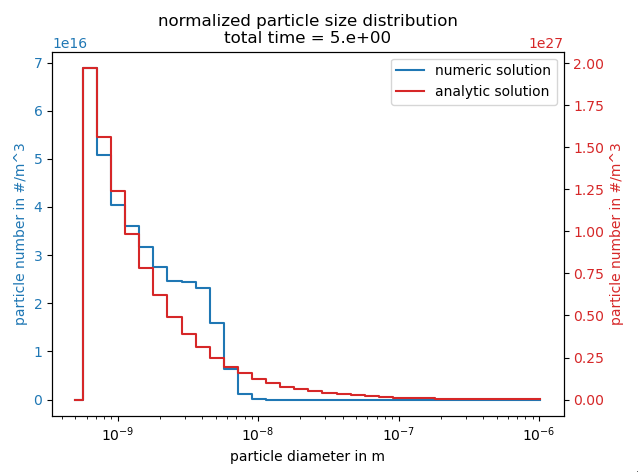

Note that the marks total to $130$ points
